# CAPSTONE 136 - Predict the Next Purchase day

In [523]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt # for visualization  
import seaborn as sns # for boxplot visualization and outlier identification
import plotly.graph_objs as go
import plotly.offline as pyoff
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler   #  for minmax scaling
from sklearn.preprocessing import QuantileTransformer  # data normalization

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import statsmodels.api as smf

In [524]:
#Import dataset from URL

url = 'https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/b60060a2-e731-4745-8d51-3db158a1add7'
df = pd.read_csv(url, sep=',', encoding ='latin1')

df.head(50)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,73,Sporting Goods,Tonawanda,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/19/2018 11:03,Standard Class
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 10:42,First Class
7,TRANSFER,2,1,68.430000,285.140015,Late delivery,1,73,Sporting Goods,Miami,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 10:21,First Class
8,CASH,3,2,133.720001,278.589996,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 10:00,Second Class
9,CASH,2,1,132.149994,275.309998,Late delivery,1,73,Sporting Goods,San Ramon,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 9:39,First Class


In [525]:
#rename columns in order to be friendly
df.columns =['Type', 'Days_shipping_real', 'Days_shipping_schedule', 'Benefit_order', 'Sales_Customer', 'Delivery_Status', 'Late_Delivery_Risk', 'Category_ID', 'Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_ID', 'Customer_Lname', 'Customer_Password', 'Customer_Segment', 'Customer_State', 'Customer_Street', 'Customer_Zipcode', 'Department_ID', 'Department_Name', 'Latitude', 'Longitude', 'Market', 'Order_City', 'Order_Country', 'Order_Customer_ID', 'Order_Date', 'Order_ID', 'OrderItem_Cardprod_ID', 'OrderItem_Discount', 'OrderItem_Discount_Rate', 'OrderItem_ID', 'OrderItem_ProductPrice', 'OrderItem_ProfitRatio', 'OrderItem_Quantity', 'Sales', 'OrderItem_Total', 'Order_Profit_Per_Order', 'Order_Region', 'Order_State', 'Order_Status', 'Order_ZipCode', 'Product_Card_ID', 'Product_Category_ID', 'Product_Description', 'Product_Image', 'Product_Name', 'Product_Price', 'Product_Status', 'Shipping_Date', 'Shipping_Mode']

In [526]:
# There are 2 datetime attributes (Order_date, Shipping_Date). I will convert to datetime 
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Shipping_Date'] = pd.to_datetime(df['Shipping_Date'])

In [527]:
#Converting attributes category to category data type.
for col in ['Type', 'Delivery_Status', 'Customer_Segment', 'Market', 'Order_Region', 'Order_Status', 'Shipping_Mode']:
    df[col] = df[col].astype('category')

In [528]:
#Converting IDs, ZipCode and Product Description columns to object
for col in ['Category_ID', 'Customer_ID', 'Department_ID', 'Order_Customer_ID', 'Order_ID', 'OrderItem_Cardprod_ID', 'OrderItem_ID', 'Product_Card_ID', 'Product_Category_ID', 'Order_ZipCode', 'Customer_Zipcode', 'Product_Description']:
    df[col] = df[col].astype('object')

In [529]:
for col in ['Late_Delivery_Risk', 'Product_Status']:
    df[col]=df[col].astype('bool')

In [530]:
#Descriptive Statistics only for object attributes Part 1
df[['Category_ID', 'Category_Name', 'Customer_City', 'Customer_Country', 'Customer_Email', 'Customer_Fname', 'Customer_ID', 'Customer_Lname', 'Customer_Password']].describe()

,Category_ID,Category_Name,Customer_City,Customer_Country,Customer_Email,Customer_Fname,Customer_ID,Customer_Lname,Customer_Password
count,180519,180519,180519,180519,180519,180519,180519,180511,180519
unique,51,50,563,2,1,782,20652,1109,1
top,17,Cleats,Caguas,EE. UU.,XXXXXXXXX,Mary,5654,Smith,XXXXXXXXX
freq,24551,24551,66770,111146,180519,65150,47,64104,180519


In [531]:
#Descriptive Statistics only for object attributes Part 2
df[['Customer_State', 'Customer_Street', 'Customer_Zipcode', 'Department_ID', 'Department_Name', 'Order_City', 'Order_Country', 'Order_Customer_ID', 'Order_ID']].describe()

,Customer_State,Customer_Street,Customer_Zipcode,Department_ID,Department_Name,Order_City,Order_Country,Order_Customer_ID,Order_ID
count,180519,180519,180516.0,180519,180519,180519,180519,180519,180519
unique,46,7458,995.0,11,11,3597,164,20652,65752
top,PR,9126 Wishing Expressway,725.0,7,Fan Shop,Santo Domingo,Estados Unidos,5654,52354
freq,69373,122,66770.0,66861,66861,2211,24840,47,5


In [532]:
#Descriptive Statistics only for object attributes Part 3
df[['OrderItem_Cardprod_ID', 'OrderItem_ID', 'Order_State', 'Order_ZipCode', 'Product_Card_ID', 'Product_Category_ID', 'Product_Description', 'Product_Image', 'Product_Name']].describe()

,OrderItem_Cardprod_ID,OrderItem_ID,Order_State,Order_ZipCode,Product_Card_ID,Product_Category_ID,Product_Description,Product_Image,Product_Name
count,180519,180519,180519,24840.0,180519,180519,0,180519,180519
unique,118,180519,1089,609.0,118,51,0,118,118
top,365,180519,Inglaterra,10035.0,365,17,NaN,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck
freq,24515,1,6722,648.0,24515,24551,NaN,24515,24515


In [533]:
#Descriptive Statistics only for category attributes 
df.describe(include=['category'])

,Type,Delivery_Status,Customer_Segment,Market,Order_Region,Order_Status,Shipping_Mode
count,180519,180519,180519,180519,180519,180519,180519
unique,4,4,3,5,23,9,4
top,DEBIT,Late delivery,Consumer,LATAM,Central America,COMPLETE,Standard Class
freq,69295,98977,93504,51594,28341,59491,107752


In [534]:
#Descriptive Statistics only for boolean attributes
df.describe(include=[np.bool])

,Late_Delivery_Risk,Product_Status
count,180519,180519
unique,2,1
top,True,False
freq,98977,180519


In [535]:
#Descriptive Statistics only for datetime attributes
df.describe(include=[np.datetime64])

,Order_Date,Shipping_Date
count,180519,180519
unique,65752,63701
top,2017-07-22 05:31:00,2015-05-21 15:34:00
freq,5,10
first,2015-01-01 00:00:00,2015-01-03 00:00:00
last,2018-01-31 23:38:00,2018-02-06 22:14:00


In [536]:
#Deleting Duplicated Attributes and Attributes which contains no values.
df = df.drop(['Benefit_order', 'Customer_Email', 'Customer_Password', 'OrderItem_ID', 'Product_Description', 'Product_Price', 'Sales_Customer'], axis=1)

In [537]:
#Checking the missing value in all the attributes
nullValues = df.isnull().sum()

print(nullValues[nullValues>0])
#There are: 8 missing value in Customer_Lname, 3 in customer_zipcode, and 155679 in Order_Zipcode.

Customer_Lname           8
Customer_Zipcode         3
Order_ZipCode       155679
dtype: int64


In [538]:
#Removing the Order_ZipCode columns as it has a lot of missing values
df = df.drop(['Order_ZipCode'], axis=1)
#Delete 11 rows
df = df.dropna()

In [539]:
df.var()

Days_shipping_real         2.636541e+00
Days_shipping_schedule     1.889131e+00
Late_Delivery_Risk         2.476688e-01
Category_ID                2.445469e+02
Customer_ID                1.732478e+07
Customer_Zipcode           1.409418e+09
Department_ID              2.654212e+00
Latitude                   9.630944e+01
Longitude                  4.593431e+02
Order_Customer_ID          1.732478e+07
Order_ID                   4.428523e+08
OrderItem_Cardprod_ID      1.131766e+05
OrderItem_Discount         4.752728e+02
OrderItem_Discount_Rate    4.958354e-03
OrderItem_ProductPrice     1.952362e+04
OrderItem_ProfitRatio      2.179078e-01
OrderItem_Quantity         2.112572e+00
Sales                      1.749556e+04
OrderItem_Total            1.440998e+04
Order_Profit_Per_Order     1.090643e+04
Product_Card_ID            1.131766e+05
Product_Category_ID        2.445469e+02
Product_Status             0.000000e+00
dtype: float64

In [540]:
#There is no variance on Product_Status attributes, so this one will be removed
df = df.drop(['Product_Status'], axis=1)

# RFM features

In [541]:
df_customer = df[['Customer_ID', 'Order_Date', 'OrderItem_Total']]

RECENCY

In [542]:
#Taking the last date where customers have made a purchase
df_Recency = df_customer.groupby('Customer_ID').Order_Date.max().reset_index()
df_Recency.columns = ['Customer_ID', 'LastPurchase']
df_Recency['Recency'] = (df_Recency['LastPurchase'].max()-df_Recency['LastPurchase']).dt.days

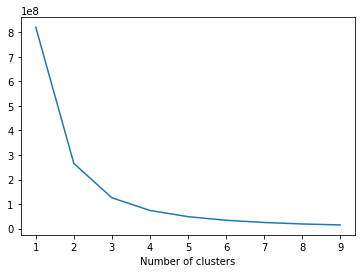

In [543]:
sse={}
df_recency = df_Recency[['Recency']]

for k in range(1,10):
        kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_recency)
        df_recency["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [544]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(df_Recency[['Recency']])
df_Recency['RecencyCluster'] =kmeans.predict(df_Recency[['Recency']])

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] =df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_Recency = order_cluster('RecencyCluster', 'Recency', df_Recency, False)

In [545]:
df_Recency.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2014.0,682.741807,148.695623,505.0,561.25,643.5,769.75,1125.0
1,6151.0,324.024711,80.134576,210.0,255.00,310.0,384.00,504.0
2,12476.0,94.300417,57.900163,0.0,45.00,91.0,140.00,209.0


FREQUENCY

In [546]:
df_Frequency = df_customer.groupby('Customer_ID').Order_Date.count().reset_index()
df_Frequency.columns = ['Customer_ID', 'Frequency']

In [547]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(df_Frequency[['Frequency']])
df_Frequency['FrequencyCluster'] =kmeans.predict(df_Frequency[['Frequency']])

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] =df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_Frequency = order_cluster('FrequencyCluster', 'Frequency', df_Frequency, True)

In [548]:
df_Frequency.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,10604.0,1.844021,1.806806,1.0,1.0,1.0,1.0,7.0
1,6569.0,12.419090,2.795868,8.0,10.0,12.0,15.0,17.0
2,3468.0,22.887255,4.647447,18.0,19.0,22.0,25.0,47.0


MONETARY

In [549]:
df_Monetary = df_customer.groupby('Customer_ID').OrderItem_Total.sum().reset_index()
df_Monetary.columns = ['Customer_ID', 'Monetary']

In [550]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(df_Monetary[['Monetary']])
df_Monetary['MonetaryCluster'] =kmeans.predict(df_Monetary[['Monetary']])

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] =df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_Monetary = order_cluster('MonetaryCluster', 'Monetary', df_Monetary, True)

In [551]:
df_Monetary.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,9966.0,328.345455,307.534736,8.470000,75.959999,247.619995,436.100006,1215.369999
1,7121.0,2109.252726,547.721907,1216.260025,1625.740006,2088.440002,2566.130043,3124.359993
2,3554.0,4152.800053,882.397425,3125.710045,3482.672532,3914.035040,4600.307571,9436.610088


In [552]:
#Creating a new dataframe with Recency, Frequency and Monetary 
dfs = [df.set_index(['Customer_ID']) for df in [df_Recency, df_Frequency, df_Monetary]]

df_RFM = pd.concat(dfs, axis=1).reset_index()

In [553]:
df_RFM['OverallScore'] = df_RFM['RecencyCluster'] + df_RFM['FrequencyCluster'] + df_RFM['MonetaryCluster']

In [554]:
df_RFM.groupby('OverallScore')['Recency', 'Frequency', 'Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,744.639744,4.057692,680.135597
1,418.890792,5.203426,886.942237
2,125.334464,2.286532,433.591757
3,300.908155,10.985641,2061.010370
4,213.946194,14.032284,2493.411147
5,275.961580,21.990260,4009.782887
6,160.954451,23.828847,4368.815845


In [555]:
df_RFM.rename(columns={'index':'Customer_ID'}, inplace=True)

In [556]:
df_RFM.head()

,Customer_ID,LastPurchase,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore
0,1,2015-12-01 22:18:00,792,0,1,0,472.450012,0,0
1,2,2017-09-17 15:04:00,136,2,10,1,1618.660042,1,4
2,3,2017-06-16 01:22:00,229,1,18,2,3189.200037,2,5
3,4,2017-01-16 18:13:00,380,1,14,1,1480.709993,1,3
4,5,2016-10-31 00:38:00,457,1,7,0,1101.919998,0,1


# CREATING THE CLASS LABEL "NextPurchaseDay"

The "NextPurchaseDay" is calculated through the average between purchases in days.
For the customers who made more or equal than 3 purchases, it will calculate the average of the last 3 purchases
For the customers who made 2 purchases, it will be the average of the 2 purchases.
For the customers who made only one purchase, it assumes that the customer made purchase in 2017, the next purchase will be in 120 days, in 2016 will be in 90 days, and 2015 will be in 60 days.

In [557]:
df_purchases = df[['Customer_ID', 'Order_Date']]
df_purchases['Order_Date'] = df_purchases['Order_Date'].dt.date
df_purchases = df_purchases.drop_duplicates(subset=['Customer_ID', 'Order_Date'], keep='first')
df_purchases['Customer_ID'] = df_purchases['Customer_ID'].apply(str)
df_purchases['Order_Date'] = pd.to_datetime(df_purchases['Order_Date'])

In [558]:
df_purchases_mean = df_purchases.sort_values(['Customer_ID', 'Order_Date'])
df_purchases_mean['T1Order_Date'] = df_purchases_mean.groupby('Customer_ID')['Order_Date'].shift(1)
df_purchases_mean['T2Order_Date'] = df_purchases_mean.groupby('Customer_ID')['Order_Date'].shift(2)
df_purchases_mean['T3Order_Date'] = df_purchases_mean.groupby('Customer_ID')['Order_Date'].shift(3)

df_purchases_mean['DayDiff'] = (df_purchases_mean['Order_Date']-df_purchases_mean['T1Order_Date'] ).dt.days
df_purchases_mean['DayDiff2'] = (df_purchases_mean['Order_Date']-df_purchases_mean['T2Order_Date']).dt.days
df_purchases_mean['DayDiff3'] = (df_purchases_mean['Order_Date']-df_purchases_mean['T3Order_Date']).dt.days

In [559]:
df_purchases_mean = df_purchases_mean.drop_duplicates(subset=['Customer_ID'],keep='last')
df_purchases_mean = df_purchases_mean.drop(['T1Order_Date', 'T2Order_Date', 'T3Order_Date', 'DayDiff2', 'DayDiff3'], axis=1)

In [560]:
# The average value of the days between orders for all of the company's orders is 194 days.
df_purchases_mean['DayDiff'].mean(skipna= True)

194.5571889870836

In [561]:
import plotly.graph_objs as go
import plotly.offline as pyoff

plot_data = [go.Histogram(x=df_purchases_mean['DayDiff'])]

plot_layout = go.Layout(title='Days')

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [562]:
#Selecting customer have made more or equal than 3 purchases
df_customer_3 = df_purchases.groupby('Customer_ID').Order_Date.count().reset_index()
df_customer_3.columns = ['Customer_ID', 'Frequency']
df_customer_3 = df_customer_3.query('Frequency>=3')
df_customer_3['Customer_ID'] = df_customer_3['Customer_ID'].apply(str)

In [563]:
df_customer_3 = pd.merge(df_customer_3[['Customer_ID']], df_purchases[['Customer_ID','Order_Date']], on='Customer_ID')
df_customer_3 = df_customer_3.sort_values(['Customer_ID','Order_Date'])

In [564]:
df_customer_3['T1Order_Date'] = df_customer_3.groupby('Customer_ID')['Order_Date'].shift(1)
df_customer_3['T2Order_Date'] = df_customer_3.groupby('Customer_ID')['Order_Date'].shift(2)
df_customer_3['T3Order_Date'] = df_customer_3.groupby('Customer_ID')['Order_Date'].shift(3)
#df_purchases.query('Customer_ID == "10010"')

In [565]:
df_customer_3['DayDiff'] = (df_customer_3['Order_Date']-df_customer_3['T1Order_Date'] ).dt.days
df_customer_3['DayDiff2'] = (df_customer_3['Order_Date']-df_customer_3['T2Order_Date']).dt.days
df_customer_3['DayDiff3'] = (df_customer_3['Order_Date']-df_customer_3['T3Order_Date']).dt.days

In [566]:
df_customer_3a = df_customer_3.groupby('Customer_ID').agg({'DayDiff': ['mean','std']}).reset_index()
df_customer_3a.columns =  ['Customer_ID', 'DayDiffMean','DayDiffStd']

In [567]:
df_customer_3 = df_customer_3.drop_duplicates(subset=['Customer_ID'],keep='last')
df_customer_3 = df_customer_3.drop(['T1Order_Date', 'T2Order_Date', 'T3Order_Date', 'DayDiff2', 'DayDiff3'], axis=1)
df_customer_3 = pd.merge(df_customer_3,df_customer_3a,on='Customer_ID', how='inner' )

In [568]:
#Selecting customer have made 2 purchases
df_customer_2 = df_purchases.groupby('Customer_ID').Order_Date.count().reset_index()
df_customer_2.columns = ['Customer_ID', 'Frequency']
df_customer_2 = df_customer_2.query('Frequency==2')
df_customer_2['Customer_ID'] = df_customer_2['Customer_ID'].apply(str)

In [569]:
df_customer_2 = pd.merge(df_customer_2[['Customer_ID']], df_purchases[['Customer_ID','Order_Date']], on='Customer_ID')
df_customer_2 = df_customer_2.sort_values(['Customer_ID','Order_Date'])

In [570]:
df_customer_2['T1Order_Date'] = df_customer_2.groupby('Customer_ID')['Order_Date'].shift(1)
df_customer_2['T2Order_Date'] = df_customer_2.groupby('Customer_ID')['Order_Date'].shift(2)
df_customer_2['T3Order_Date'] = df_customer_2.groupby('Customer_ID')['Order_Date'].shift(3)

In [571]:
df_customer_2['DayDiff'] = (df_customer_2['Order_Date']-df_customer_2['T1Order_Date'] ).dt.days
df_customer_2['DayDiff2'] = (df_customer_2['Order_Date']-df_customer_2['T2Order_Date']).dt.days
df_customer_2['DayDiff3'] = (df_customer_2['Order_Date']-df_customer_2['T3Order_Date']).dt.days

In [572]:
df_customer_2a = df_customer_2.groupby('Customer_ID').agg({'DayDiff': ['mean','std']}).reset_index()
df_customer_2a.columns =  ['Customer_ID', 'DayDiffMean','DayDiffStd']

In [573]:
df_customer_2 = df_customer_2.drop_duplicates(subset=['Customer_ID'],keep='last')
df_customer_2 = df_customer_2.drop(['T1Order_Date', 'T2Order_Date', 'T3Order_Date', 'DayDiff2', 'DayDiff3'], axis=1)
df_customer_2 = pd.merge(df_customer_2,df_customer_2a,on='Customer_ID', how='inner' )
df_customer_2 = df_customer_2.fillna(0)

In [574]:
df_customer_2.head()

,Customer_ID,Order_Date,DayDiff,DayDiffMean,DayDiffStd
0,10,2017-03-30,159.0,159.0,0.0
1,10000,2017-10-02,920.0,920.0,0.0
2,10002,2016-09-22,555.0,555.0,0.0
3,10016,2016-10-28,287.0,287.0,0.0
4,10028,2017-06-09,554.0,554.0,0.0


In [575]:
#Selecting customer have made 1 purchase
df_customer_1 = df_purchases.groupby('Customer_ID').Order_Date.count().reset_index()
df_customer_1.columns = ['Customer_ID', 'Frequency']
df_customer_1 = df_customer_1.query('Frequency==1')
df_customer_1['Customer_ID'] = df_customer_1['Customer_ID'].apply(str)
df_customer_1 = pd.merge(df_customer_1[['Customer_ID']], df_purchases[['Customer_ID','Order_Date']], on='Customer_ID')

df_customer_1['DayDiff'] = 60
df_customer_1.loc[df_customer_1['Order_Date'].dt.year ==2016, 'DayDiff'] = 90
df_customer_1.loc[df_customer_1['Order_Date'].dt.year ==2017, 'DayDiff'] = 120
df_customer_1a = df_customer_1.groupby('Customer_ID').agg({'DayDiff': ['mean','std']}).reset_index()
df_customer_1a.columns =  ['Customer_ID', 'DayDiffMean','DayDiffStd']

df_customer_1 = pd.merge(df_customer_1,df_customer_1a,on='Customer_ID', how='inner' )
df_customer_1['DayDiffStd'] = 0

In [576]:
df_customer = df_customer_3.append(df_customer_2)
df_customer = df_customer.append(df_customer_1)
df_customer.columns=['Customer_ID', 'Order_Date', 'NextPurchaseDay', 'DayDiffMean', 'DayDiffStd']

In [577]:
df_customer.head()

,Customer_ID,Order_Date,NextPurchaseDay,DayDiffMean,DayDiffStd
0,100,2017-07-29,22.0,168.80,136.735877
1,1000,2017-07-04,74.0,124.60,72.624376
2,10001,2017-08-10,153.0,208.25,56.923194
3,10003,2017-09-23,131.0,206.75,86.919024
4,10004,2017-08-18,340.0,318.00,21.517435


# Scaling & Normalizing the data - For the outlier detection tool

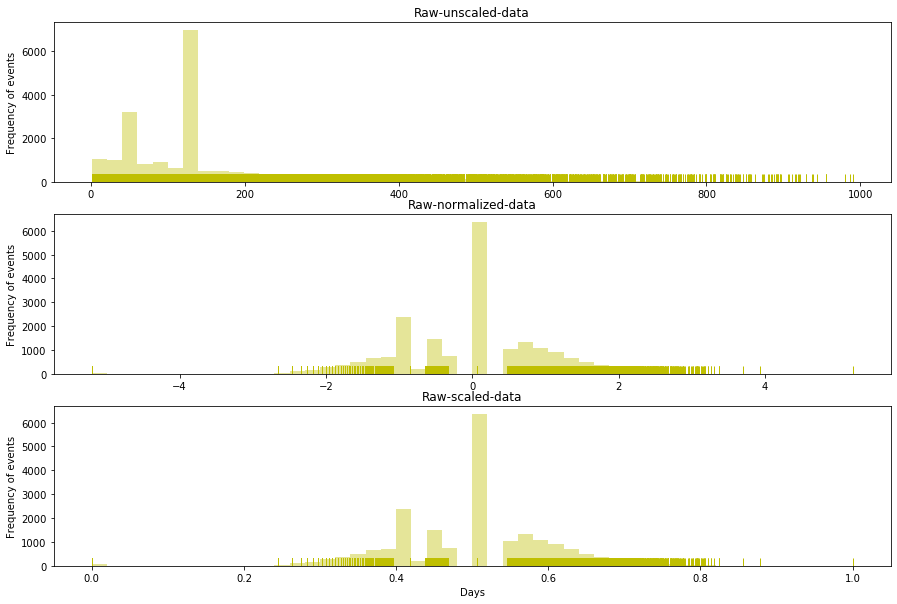

In [578]:
#Scaling & Normalizing the data - For the outlier detection tool 
s_npd = pd.Series(df_customer['NextPurchaseDay'])
x_npd = np.array(s_npd)

#df_customer['NextPurchaseDay'].to_numpy()
qt_npd = QuantileTransformer(output_distribution='normal')
df_customer['x_npd']= qt_npd.fit_transform(x_npd.reshape(-1, 1))

# rescale the values - using minmax
scaler = MinMaxScaler()
s_xnpd = pd.Series(df_customer['x_npd'])
a_xnpd = np.array(s_xnpd)
df_customer['y_npd'] = scaler.fit_transform(a_xnpd.reshape(-1, 1))

#Plotting the above using Seaborn
f,axes = plt.subplots(3,1)
f.set_figheight(10)
f.set_figwidth(15) 

sns.distplot(x_npd,color='y',kde= False, bins = 50, norm_hist= False,  rug= True , ax=axes[0])
 
sns.distplot(df_customer['x_npd'],color='y',kde= False, bins = 50, norm_hist= False,  rug= True ,  ax=axes[1])
 
sns.distplot(df_customer['y_npd'], color='y',kde= False, bins = 50, norm_hist= False,  rug= True , ax=axes[2])

axes[0].set_title('Raw-unscaled-data')
axes[1].set_title('Raw-normalized-data')
axes[2].set_title('Raw-scaled-data')

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('Days')

axes[0].set_ylabel('Frequency of events')
axes[1].set_ylabel('Frequency of events')
axes[2].set_ylabel('Frequency of events')

display()

In [579]:
# quartile calculation and outlier cut-off determination
# strech mutiplier
smp_s = 1.5

y_npd_q1_s = np.percentile(df_customer['y_npd'], 25)
y_npd_q3_s = np.percentile(df_customer['y_npd'], 75)

c_npd_o2_s = y_npd_q3_s + (y_npd_q3_s - y_npd_q1_s)*smp_s
c_npd_o1_s = y_npd_q1_s - (y_npd_q3_s - y_npd_q1_s)*smp_s

print('The cut-off values for the outliers are ', 'c_npd_o1_s =', c_npd_o1_s, 'and ' 'c_npd_o2_s = ', c_npd_o2_s)

df_customer['npd_outlier'] = df_customer['y_npd'].apply(lambda x: 1 if x < c_npd_o1_s else 0)
df_customer['npd_outlier'] = df_customer['y_npd'].apply(lambda x: 1 if x > c_npd_o2_s else 0)

The cut-off values for the outliers are  c_npd_o1_s = 0.19956471953936805 and c_npd_o2_s =  0.7841632446448691


In [580]:
# Outlier tool
print('No of Outliers detected', df_customer[df_customer['npd_outlier'] == 1].shape[0])
print('The Outliers represents 0.17% *thus many outliers detected by earlier method may not be true outliers and rather due to non-normal distribution of the data are appearing as outliers by simple defintion of mean/1.5sigma rule to detect outliers')

No of Outliers detected 35
The Outliers represents 0.17% *thus many outliers detected by earlier method may not be true outliers and rather due to non-normal distribution of the data are appearing as outliers by simple defintion of mean/1.5sigma rule to detect outliers


# Quantile method will be used to classify the NextPurchaseDay column

In [581]:
Percentile_min = df_customer['NextPurchaseDay'].min()
Percentile_25 = df_customer['NextPurchaseDay'].quantile(.25)
Percentile_75 = df_customer['NextPurchaseDay'].quantile(.75)

In [582]:
df_customer['NextPurchaseDayCluster'] = 2
df_customer.loc[df_customer['NextPurchaseDay']>=Percentile_25, 'NextPurchaseDayCluster'] = 1
df_customer.loc[df_customer['NextPurchaseDay']>=Percentile_75, 'NextPurchaseDayCluster'] = 0

In [583]:
df_customer.groupby('NextPurchaseDayCluster')['Customer_ID'].describe()

,count,unique,top,freq
NextPurchaseDayCluster,,,,
0,5176,5176,11440,1
1,12550,12550,13047,1
2,2915,2915,3868,1


In [584]:
df_model = df_customer.query('npd_outlier == 0')
df_model.head()

,Customer_ID,Order_Date,NextPurchaseDay,DayDiffMean,DayDiffStd,x_npd,y_npd,npd_outlier,NextPurchaseDayCluster
0,100,2017-07-29,22.0,168.80,136.735877,-1.597698,0.346356,0,2
1,1000,2017-07-04,74.0,124.60,72.624376,-0.574595,0.444743,0,1
2,10001,2017-08-10,153.0,208.25,56.923194,0.611996,0.558853,0,1
3,10003,2017-09-23,131.0,206.75,86.919024,0.522099,0.550208,0,1
4,10004,2017-08-18,340.0,318.00,21.517435,1.261282,0.621293,0,0


In [641]:
df_RFM.groupby('OverallScore')['Customer_ID'].count()

OverallScore
0     780
1     934
2    9430
3    3691
4    2509
5    1848
6    1449
Name: Customer_ID, dtype: int64

# Final model with all the attributes and class label

In [585]:
#Adding RFM and class label to the Data frame (source) 
df['Customer_ID'] = df['Customer_ID'].apply(str)
df_RFM['Customer_ID'] = df_RFM['Customer_ID'].apply(str)

df_final1 = pd.merge(df, df_RFM[['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'OverallScore']], on='Customer_ID', how='inner')

df_final = pd.merge(df_final1, df_model[['Customer_ID','DayDiffMean', 'DayDiffStd','NextPurchaseDayCluster', 'npd_outlier']], on='Customer_ID', how='inner')

In [586]:
df_final.head()

,Type,Days_shipping_real,Days_shipping_schedule,Delivery_Status,Late_Delivery_Risk,Category_ID,Category_Name,Customer_City,Customer_Country,Customer_Fname,...,Shipping_Date,Shipping_Mode,Recency,Frequency,Monetary,OverallScore,DayDiffMean,DayDiffStd,NextPurchaseDayCluster,npd_outlier
0,DEBIT,3,4,Advance shipping,False,73,Sporting Goods,Caguas,Puerto Rico,Cally,...,2018-02-03 22:56:00,Standard Class,0,1,314.640015,2,60.0,0.0,1,0
1,TRANSFER,5,4,Late delivery,True,73,Sporting Goods,Caguas,Puerto Rico,Irene,...,2018-01-18 12:27:00,Standard Class,18,1,311.359985,2,60.0,0.0,1,0
2,CASH,4,4,Shipping on time,False,73,Sporting Goods,San Jose,EE. UU.,Gillian,...,2018-01-17 12:06:00,Standard Class,18,1,309.720001,2,60.0,0.0,1,0
3,DEBIT,3,4,Advance shipping,False,73,Sporting Goods,Los Angeles,EE. UU.,Tana,...,2018-01-16 11:45:00,Standard Class,18,1,304.809998,2,60.0,0.0,1,0
4,PAYMENT,2,4,Advance shipping,False,73,Sporting Goods,Caguas,Puerto Rico,Orli,...,2018-01-15 11:24:00,Standard Class,18,1,298.250000,2,60.0,0.0,1,0


# FEATURE SELECTION

In [587]:
# I have to split the dataset in two parts in order to do the feature selection, due to memory problems.
# One part will run categorical variable and another will run numerical variable

#Category attibutes
df_final.iloc[:,[0,3,12,20,35,37,43]]

#Numeric Attibutes
df_final.iloc[:,[1,2,4,18,19,27,28,29,30,31,32,33,34,44,45,46,47,48,49]]

,Days_shipping_real,Days_shipping_schedule,Late_Delivery_Risk,Latitude,Longitude,OrderItem_Discount,OrderItem_Discount_Rate,OrderItem_ProductPrice,OrderItem_ProfitRatio,OrderItem_Quantity,Sales,OrderItem_Total,Order_Profit_Per_Order,Recency,Frequency,Monetary,OverallScore,DayDiffMean,DayDiffStd
0,3,4,False,18.251453,-66.037056,13.110000,0.04,327.750000,0.29,1,327.750000,314.640015,91.250000,0,1,314.640015,2,60.0,0.0
1,5,4,True,18.279451,-66.037064,16.389999,0.05,327.750000,-0.80,1,327.750000,311.359985,-249.089996,18,1,311.359985,2,60.0,0.0
2,4,4,False,37.292233,-121.881279,18.030001,0.06,327.750000,-0.80,1,327.750000,309.720001,-247.779999,18,1,309.720001,2,60.0,0.0
3,3,4,False,34.125946,-118.291016,22.940001,0.07,327.750000,0.08,1,327.750000,304.809998,22.860001,18,1,304.809998,2,60.0,0.0
4,2,4,False,18.253769,-66.037048,29.500000,0.09,327.750000,0.45,1,327.750000,298.250000,134.210007,18,1,298.250000,2,60.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180257,4,2,True,18.275261,-66.037056,14.790000,0.09,164.380005,0.30,1,164.380005,149.589996,44.880001,31,1,149.589996,2,120.0,0.0
180258,5,2,True,18.223066,-66.037056,31.280001,0.12,260.649994,-0.14,1,260.649994,229.369995,-31.650000,64,1,229.369995,2,120.0,0.0
180259,2,2,False,18.240482,-66.037064,29.590000,0.18,164.380005,0.48,1,164.380005,134.789993,64.699997,31,1,134.789993,2,120.0,0.0
180260,2,2,False,18.261297,-66.037056,52.130001,0.20,260.649994,-0.30,1,260.649994,208.520004,-62.560001,65,1,208.520004,2,120.0,0.0


In [588]:
#Model with categorical variables
df_model_1 = df_final.iloc[:,[-2,0,3,12,20,35,37,43]]
df_model_1.dropna(inplace=True)
df_model_1 = df_model_1.sample(frac=0.01)

In [589]:
df_model_1.head()

,NextPurchaseDayCluster,Type,Delivery_Status,Customer_Segment,Market,Order_Region,Order_Status,Shipping_Mode
34143,0,DEBIT,Late delivery,Consumer,LATAM,Caribbean,ON_HOLD,First Class
13055,1,DEBIT,Late delivery,Home Office,Pacific Asia,Southeast Asia,COMPLETE,Standard Class
160897,2,PAYMENT,Advance shipping,Home Office,USCA,West of USA,PENDING_PAYMENT,Standard Class
176494,1,TRANSFER,Late delivery,Consumer,Europe,Western Europe,PENDING,Standard Class
114932,0,DEBIT,Late delivery,Consumer,LATAM,Caribbean,COMPLETE,First Class


In [590]:
#Model with numerical variables
df_model_2 = df_final.iloc[:,[-2,1,2,4,18,19,27,28,29,30,31,32,33,34,44,45,46,47,48,49]]
df_model_2.dropna(inplace=True)
#Convert column Late Delivery Risk as binary (0/1)
df_model_2[['Late_Delivery_Risk']] = (df_model_2[['Late_Delivery_Risk']] == 'True').astype(int)
df_model_2 = df_model_2.sample(frac=0.01)

In [591]:
df_model_2.head()

,NextPurchaseDayCluster,Days_shipping_real,Days_shipping_schedule,Late_Delivery_Risk,Latitude,Longitude,OrderItem_Discount,OrderItem_Discount_Rate,OrderItem_ProductPrice,OrderItem_ProfitRatio,OrderItem_Quantity,Sales,OrderItem_Total,Order_Profit_Per_Order,Recency,Frequency,Monetary,OverallScore,DayDiffMean,DayDiffStd
92817,2,4,2,0,38.514503,-121.873741,3.0,0.01,299.980011,0.49,1,299.980011,296.980011,145.520004,265,17,2927.090023,3,138.400000,127.012991
141597,2,4,2,0,18.269371,-66.370514,20.0,0.10,39.990002,0.46,5,199.949997,179.960007,82.779999,268,9,1478.240013,3,187.750000,163.361307
165764,1,2,2,0,37.344669,-122.035667,10.0,0.04,50.000000,0.38,5,250.000000,240.000000,91.199997,182,19,3534.720070,6,109.400000,56.628615
8117,1,2,4,0,40.249317,-75.255386,4.5,0.09,49.980000,-0.77,1,49.980000,45.480000,-34.880001,190,13,2224.980042,4,184.666667,109.600791
122128,0,2,4,0,18.272686,-66.370613,18.0,0.09,199.990005,0.47,1,199.990005,181.990005,85.540001,218,20,2850.000006,4,173.000000,111.796690


# Numerical Variables

In [592]:
X = df_model_2.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]] #independent columns
y = df_model_2.iloc[:,0]    #target column 

#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#fit the model
RF= RandomForestClassifier()  
RF.fit(X_train, y_train) 

#predict
y_pred= RF.predict(X_test)  

print('Train Score Random Forest: ', RF.score(X_train, y_train))  
print('Test Score Random Forest: ', RF.score(X_test, y_test))

Train Score Random Forest:  1.0
Test Score Random Forest:  0.5360443622920518


In [593]:
#fit the model
LR = LinearRegression()  
LR.fit(X_train, y_train) 

#predict
y_pred= LR.predict(X_test)  

print('Train Score Linear Regression: ', LR.score(X_train, y_train))  
print('Test Score Linear Regression: ', LR.score(X_test, y_test))

Train Score Linear Regression:  0.17258503370928258
Test Score Linear Regression:  0.15373295870253856


In [594]:
#fit the model
LG = LogisticRegression()  
LG.fit(X_train, y_train) 

#predict
y_pred= LG.predict(X_test)  

print('Train Score Logistic Regression: ', LG.score(X_train, y_train))  
print('Test Score Logistic Regression: ', LG.score(X_test, y_test))

Train Score Logistic Regression:  0.5332805071315373
Test Score Logistic Regression:  0.5360443622920518


As the test shows above, Logistic Regression method has better results than Random Forest and Linear Regression. Then, Logistic Regression will be used for numerical attributes.

# Logistic Regression Model for  "Numerical Values"

The Backward Elimination was used.

In [595]:
sbs = SFS(LogisticRegression(), k_features=10, forward=False, floating=False, cv=0)
sbs.fit(X, y)
sbs.k_feature_names_

('Days_shipping_schedule',
 'Latitude',
 'Longitude',
 'OrderItem_ProfitRatio',
 'Sales',
 'OrderItem_Total',
 'Recency',
 'OverallScore',
 'DayDiffMean',
 'DayDiffStd')

# Categorical Variables

In [617]:
X = df_model_1.iloc[:,[1,2,3,4,5,6,7]] #independent columns
y = df_model_1.iloc[:,0]    #target column 

X = pd.get_dummies(X)

#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#fit the model
RF= RandomForestClassifier()  
RF.fit(X_train, y_train) 

#predict
y_pred= RF.predict(X_test)  

print('Train Score Random Forest: ', RF.score(X_train, y_train))  
print('Test Score Random Forest: ', RF.score(X_test, y_test))

Train Score Random Forest:  0.7908082408874801
Test Score Random Forest:  0.3789279112754159


In [597]:
#fit the model
LR = LinearRegression()  
LR.fit(X_train, y_train) 

#predict
y_pred= LR.predict(X_test)  

print('Train Score Linear Regression: ', LR.score(X_train, y_train))  
print('Test Score Linear Regression: ', LR.score(X_test, y_test))

Train Score Linear Regression:  0.0075803557906823915
Test Score Linear Regression:  -0.08250875358392218


In [618]:
#fit the model
LG = LogisticRegression()  
LG.fit(X_train, y_train) 

#predict
y_pred= LG.predict(X_test)  

print('Train Score Logistic Regression: ', LG.score(X_train, y_train))  
print('Test Score Logistic Regression: ', LG.score(X_test, y_test))

Train Score Logistic Regression:  0.4318541996830428
Test Score Logistic Regression:  0.3955637707948244


Logistic Regression shows better results than RAndom Forest and Linear Regression for Categorical Variables

# Logistic Regression Model for "Categorical attributes"

The process will be the same as that used for Numerical attributes

In [619]:
sbs = SFS(LogisticRegression(), k_features=5, forward=False, floating=False, cv=0)
sbs.fit(X, y)
sbs.k_feature_names_

('Delivery_Status_Shipping canceled',
 'Customer_Segment_Consumer',
 'Market_Africa',
 'Order_Region_Northern Europe',
 'Shipping_Mode_First Class')

# Putting Numerical and Categorical model together

In [620]:
df_final_model = df_final.iloc[:,[-2,2,3,12,18,19,20,30,32,33,35,43,44,47,48,49]]
df_final_model = df_final_model.sample(frac=0.01)

In [621]:
df_final_model.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]

,Days_shipping_schedule,Delivery_Status,Customer_Segment,Latitude,Longitude,Market,OrderItem_ProfitRatio,Sales,OrderItem_Total,Order_Region,Shipping_Mode,Recency,OverallScore,DayDiffMean,DayDiffStd
175790,1,Late delivery,Consumer,33.863297,-117.971626,Pacific Asia,-2.70,164.380005,136.440002,Eastern Asia,First Class,30,2,120.000000,0.000000
32269,4,Shipping on time,Home Office,18.225782,-66.370590,LATAM,-0.23,59.990002,57.590000,Caribbean,Standard Class,209,4,302.666667,141.196081
178465,4,Late delivery,Home Office,18.205240,-66.037056,Pacific Asia,0.03,164.380005,159.449997,Southeast Asia,Standard Class,81,2,120.000000,0.000000
155433,4,Advance shipping,Consumer,34.003098,-118.287109,USCA,-0.16,49.980000,45.480000,West of USA,Standard Class,317,3,131.250000,97.667378
35183,2,Late delivery,Consumer,18.208597,-66.370522,Pacific Asia,0.35,119.980003,116.379997,Eastern Asia,Second Class,473,5,146.500000,89.287924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22044,4,Late delivery,Consumer,36.111179,-115.211029,USCA,0.49,129.990005,128.690002,West of USA,Standard Class,225,5,176.400000,189.446035
112396,1,Late delivery,Consumer,18.259209,-66.370621,LATAM,0.49,250.000000,220.000000,South America,First Class,703,3,67.200000,50.534147
25140,4,Advance shipping,Corporate,39.960236,-76.676758,USCA,0.01,199.990005,159.990005,South of USA,Standard Class,331,3,178.500000,113.844192
160541,0,Shipping on time,Home Office,33.948570,-117.424721,Europe,0.02,199.949997,197.949997,Southern Europe,Same Day,190,6,125.428571,127.753483


# Dealing with Imbalance Data

In [602]:
df_final_model.groupby('NextPurchaseDayCluster').NextPurchaseDayCluster.count()

NextPurchaseDayCluster
0    660
1    675
2    468
Name: NextPurchaseDayCluster, dtype: int64

In [603]:
df_NextPurchaseDay_count = df_final_model.groupby('NextPurchaseDayCluster').size().reset_index(name='count')
df_NextPurchaseDay_count.columns = ['NextPurchaseDayCluster', 'Cnt']

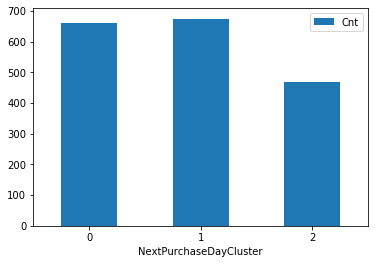

In [604]:
df_NextPurchaseDay_count.plot.bar(x='NextPurchaseDayCluster', y='Cnt', rot=0)

In [622]:
from imblearn.over_sampling import SMOTE

X = df_final_model.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]#independent columns
y = df_final_model.iloc[:,0]    #target column 

X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train, y_train)

# Building model

# Using percentage correctly classified (PCC) or Accuracy indicator

In [623]:
# prepare models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))

LR: 0.526193 (0.057904)
NB: 0.450099 (0.113782)
RF: 0.620406 (0.114420)
SVC: 0.539202 (0.060473)


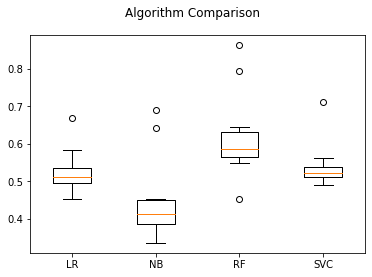

In [624]:
#evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_results = cross_val_score(model, X_sm, y_sm, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg ="%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# ROC for multiple class label

In [625]:
X = df_final_model.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14]]#independent columns
y = df_final_model.iloc[:,0]    #target column 

X=pd.get_dummies(X)
y = label_binarize(y, classes=[0, 1, 2])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train, y_train)

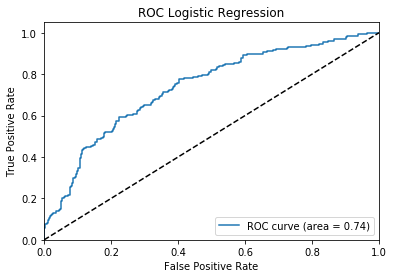

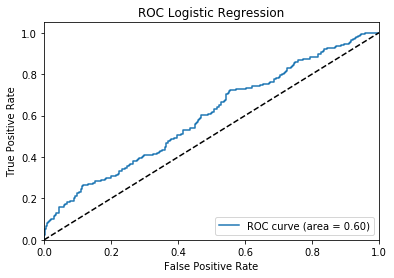

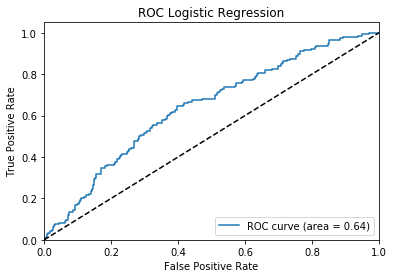

In [626]:
# Create classifiers
clf = OneVsRestClassifier(LogisticRegression())

y_score = clf.fit(X_sm, y_sm).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

In [627]:
roc_auc

{0: 0.735882282712512, 1: 0.5959785133565622, 2: 0.6397809963616009}

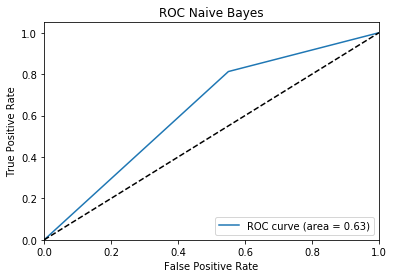

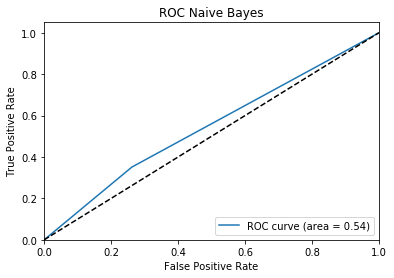

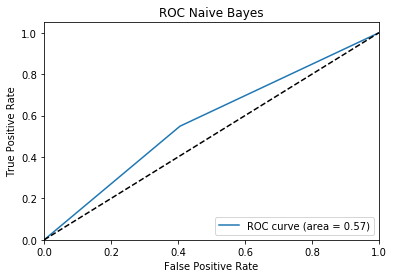

In [628]:
# Create classifiers
clf = OneVsRestClassifier(GaussianNB())

y_score = clf.fit(X_sm, y_sm).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Naive Bayes')
    plt.legend(loc="lower right")
    plt.show()

In [629]:
roc_auc

{0: 0.6311783667621776, 1: 0.54465737514518, 2: 0.5715347746991324}

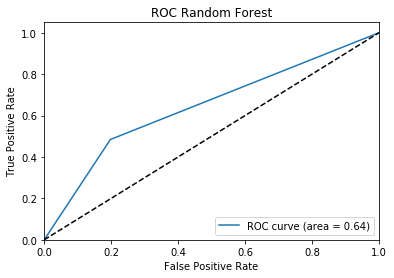

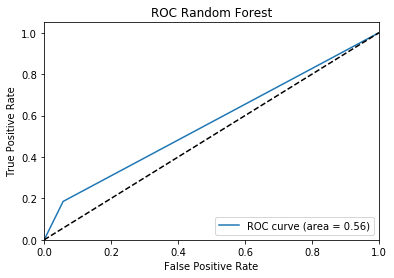

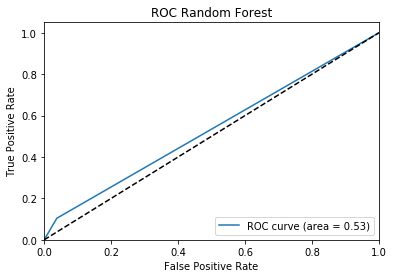

In [630]:
# Create classifiers
clf = OneVsRestClassifier(RandomForestClassifier())

y_score = clf.fit(X_sm, y_sm).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Random Forest')
    plt.legend(loc="lower right")
    plt.show()

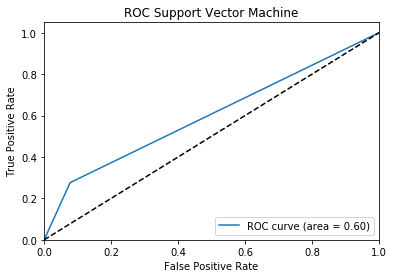

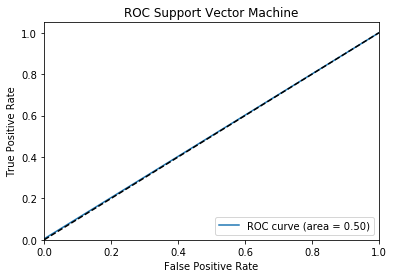

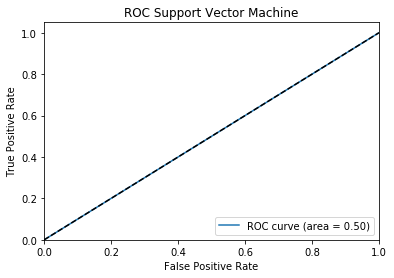

In [631]:
# Create classifiers
clf = OneVsRestClassifier(SVC(probability = True))

y_score = clf.fit(X_sm, y_sm).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Support Vector Machine')
    plt.legend(loc="lower right")
    plt.show()

In [632]:
roc_auc

{0: 0.5993388849092646, 1: 0.5024390243902439, 2: 0.5}